In [1]:
import pandas as pd
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
seed = 50
from sklearn.model_selection import KFold

# softmax function

In [2]:
def softmax(z):
    exp_z = np.exp(z)  # Compute the exponentials

    # Calculate softmax output
    softmax_result = exp_z / np.sum(exp_z, axis=1, keepdims=True)

    return softmax_result

# SGD class

In [3]:


class SGD:

    def __init__(self, learning_rate=0.001, max_iters=1e5, epsilon=1e-8, record_history=True, verbose=False , batch_size=64):
        self.learning_rate = learning_rate  # Learning rate
        self.max_iters = max_iters  # Maximum number of iterations
        self.record_history = record_history  # Whether to record the history of weights
        self.epsilon = epsilon  # Convergence precision
        self.batch_size = batch_size  # Size of mini-batch
        self.verbose = verbose #
        if record_history:
            self.w_history = []  # List to store the history of weights for visualization
            self.grad_history = [] # List to store gradient
            self.loss_history = [] # List to store gradient

    def run(self, gradient_fn, X, y, w):
        grad = np.inf
        t = 1
        while t < self.max_iters:
            indices = np.random.choice(len(X), self.batch_size, replace=False)  # Randomly select indices for a mini-batch
            x_batch = X[indices, :]
            y_batch = y[indices, :]
            grad, loss = gradient_fn(x_batch, y_batch, w)  # Calculate the gradient using the mini-batch
            # print(f"grad{t} = {np.linalg.norm(grad, ord=2)}")
            w = w - self.learning_rate * grad  # Weight update step
            if self.record_history:
                self.w_history.append(w)
                # self.grad_history.append(np.linalg.norm(grad, ord=2))
                self.grad_history.append(grad)
                self.loss_history.append(loss)
            t += 1
            
        # Print training information if needed
        if self.verbose:
            print(f'Terminated after {t} iterations, with the norm of the gradient equal to {np.linalg.norm(grad)}')
            # print(f'The weight found:\n{w}')
            
        return w

# Softmax Regression class

In [4]:
class SoftmaxRegression:
    def __init__(self, add_bias=True):
        # Initialize model parameters
        self.add_bias = add_bias

    def fit(self, X, y, optimizer):
        # Add a bias column if needed
        if self.add_bias:
            N = X.shape[0]
            X = np.column_stack([X, np.ones(N)])
        N, D = X.shape
        self.w = np.zeros((D, y.shape[1]))  # Initialize weights
        
        def gradient(X, y, w):
            # Compute the gradient of the cost function
            N, D = X.shape
            yh = softmax(np.dot(X, w))  # Predictions size N
            grad = np.dot(X.T, yh - y) / N  # Divide by N because the cost is the mean over N points
            loss = np.mean(np.abs(yh - y))
            return grad, loss
        
        self.w = optimizer.run(gradient, X, y, self.w)
        return self

    def predict(self, X):
        # Add a bias column if needed
        if self.add_bias:
            Nt = X.shape[0]
            X = np.column_stack([X, np.ones(Nt)])

        # Compute softmax class probabilities
        softmax_scores = softmax(np.dot(X, self.w))
        return softmax_scores


# Helper function

In [5]:
# function for MSE
calculate_mse = lambda true, predicted: ((true - predicted) ** 2).mean()


def accuracy_score_custom(y_true, y_pred):
    sample_accuracy = np.all(y_true == y_pred, axis=1)
    return np.mean(sample_accuracy)

def precision_score_custom(y_true, y_pred):
    num_classes = y_true.shape[1]
    class_precisions = []
    for cls in range(num_classes):
        true_positives = np.sum((y_true[:, cls] == 1) & (y_pred[:, cls] == 1))
        predicted_positives = np.sum(y_pred[:, cls] == 1)
        precision = true_positives / predicted_positives if predicted_positives != 0 else 0
        class_precisions.append(precision)
    return np.mean(class_precisions)

def recall_score_custom(y_true, y_pred):
    num_classes = y_true.shape[1]
    class_recalls = []
    for cls in range(num_classes):
        true_positives = np.sum((y_true[:, cls] == 1) & (y_pred[:, cls] == 1))
        actual_positives = np.sum(y_true[:, cls] == 1)
        recall = true_positives / actual_positives if actual_positives != 0 else 0
        class_recalls.append(recall)
    return np.mean(class_recalls)

def f1_score_custom(y_true, y_pred):
    num_classes = y_true.shape[1]
    class_f1_scores = []
    for cls in range(num_classes):
        precision = precision_score_custom(y_true[:, [cls]], y_pred[:, [cls]])
        recall = recall_score_custom(y_true[:, [cls]], y_pred[:, [cls]])
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
        class_f1_scores.append(f1_score)
    return np.mean(class_f1_scores)


# load wine dataset

In [6]:
# Read the CSV file containing data
data = np.genfromtxt('wine_clean.csv', delimiter=',', skip_header=1)

# Extract the first column as the target array y
y = data[:, 0]

# Extract all the remaining columns as the feature matrix X
X = data[:, 1:]

# Subtract 1 from y to map class labels to 0, 1, 2
y -= 1

# Create one-hot encoding using NumPy
num_samples = len(y)
num_classes = 3

y_one_hot = np.zeros((num_samples, num_classes))
y_one_hot[np.arange(num_samples), y.astype(int)] = 1
y = y_one_hot

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=50)

# Print the shapes of various data
print("Shape of y:", y.shape)
print("Shape of X:", X.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_train:", X_train.shape)
print("Shape of y_test:", y_test.shape)
print("Shape of X_test:", X_test.shape)


Shape of y: (178, 3)
Shape of X: (178, 13)
Shape of y_train: (142, 3)
Shape of X_train: (142, 13)
Shape of y_test: (36, 3)
Shape of X_test: (36, 13)


# Test the performance metric of the model

In [32]:
# Set a fixed random seed for reproducibility
np.random.seed(seed)

# Create the optimizer
optimizer = SGD(learning_rate=1/1e+5, max_iters=5000, verbose=False, batch_size=64)

# Initialize the softmax regression model
model_softmax = SoftmaxRegression()

# Fit the model to the training data
model_softmax.fit(X_train, y_train, optimizer)

# Predict on the test data
y_train_pred = model_softmax.predict(X_test)

argmax_indices = np.argmax(y_train_pred, axis=1)
prediction = np.zeros_like(y_train_pred)
prediction[np.arange(len(y_train_pred)), argmax_indices] = 1

# Calculate accuracy
accuracy = accuracy_score_custom(y_test, prediction)

# Calculate precision
precision = precision_score_custom(y_test, prediction)

# Calculate recall
recall = recall_score_custom(y_test, prediction)

# Calculate F1 score
f1 = f1_score_custom(y_test, prediction)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.81
Precision: 0.87
Recall: 0.79
F1 Score: 0.80


In [33]:
# Set a fixed random seed for reproducibility
np.random.seed(seed)

# Create the optimizer
optimizer = SGD(learning_rate=1/1e+5, max_iters=5000, verbose=False, batch_size=64)

# Initialize the softmax regression model
model_softmax = SoftmaxRegression()

# Fit the model to the training data
model_softmax.fit(X_train, y_train, optimizer)

# Predict on the test data
y_train_pred = model_softmax.predict(X_train)

argmax_indices = np.argmax(y_train_pred, axis=1)
prediction = np.zeros_like(y_train_pred)
prediction[np.arange(len(y_train_pred)), argmax_indices] = 1

# Calculate accuracy
accuracy = accuracy_score_custom(y_train, prediction)

# Calculate precision
precision = precision_score_custom(y_train, prediction)

# Calculate recall
recall = recall_score_custom(y_train, prediction)

# Calculate F1 score
f1 = f1_score_custom(y_train, prediction)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.75
Precision: 0.84
Recall: 0.72
F1 Score: 0.71


# Test the performance metric of the model with 5-cross validation

In [34]:
# Set a fixed random seed for reproducibility
np.random.seed(seed)

# Create the optimizer
optimizer = SGD(learning_rate=1/1e+5, max_iters=5000, verbose=False, batch_size=64)

# Initialize the softmax regression model
model_softmax = SoftmaxRegression()

# Initialize lists to store performance metrics
accuracies = []
precisions = []
recalls = []
f1_scores = []

# Initialize 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=seed)

# Perform 5-fold cross-validation
for train_index, test_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[test_index]

    # Fit the model to the training fold
    model_softmax.fit(X_train_fold, y_train_fold, optimizer)

    # Predict on the validation fold
    y_val_pred = model_softmax.predict(X_val_fold)

    # Convert probabilities to classes
    argmax_indices = np.argmax(y_val_pred, axis=1)
    prediction = np.zeros_like(y_val_pred)
    prediction[np.arange(len(y_val_pred)), argmax_indices] = 1

    # Calculate performance metrics for this fold
    accuracy = accuracy_score_custom(y_val_fold, prediction)
    precision = precision_score_custom(y_val_fold, prediction)
    recall = recall_score_custom(y_val_fold, prediction)
    f1 = f1_score_custom(y_val_fold, prediction)

    # Store the metrics for this fold
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

# Calculate the average performance metrics across all folds
avg_accuracy = np.mean(accuracies)
avg_precision = np.mean(precisions)
avg_recall = np.mean(recalls)
avg_f1_score = np.mean(f1_scores)

# Print the average performance metrics
print(f"5-cross_Average Accuracy: {avg_accuracy:.2f}")
print(f"5-cross_Average Precision: {avg_precision:.2f}")
print(f"5-cross_Average Recall: {avg_recall:.2f}")
print(f"5-cross_Average F1 Score: {avg_f1_score:.2f}")


5-cross_Average Accuracy: 0.74
5-cross_Average Precision: 0.72
5-cross_Average Recall: 0.72
5-cross_Average F1 Score: 0.69


# Test the Model Performance with different size of training set

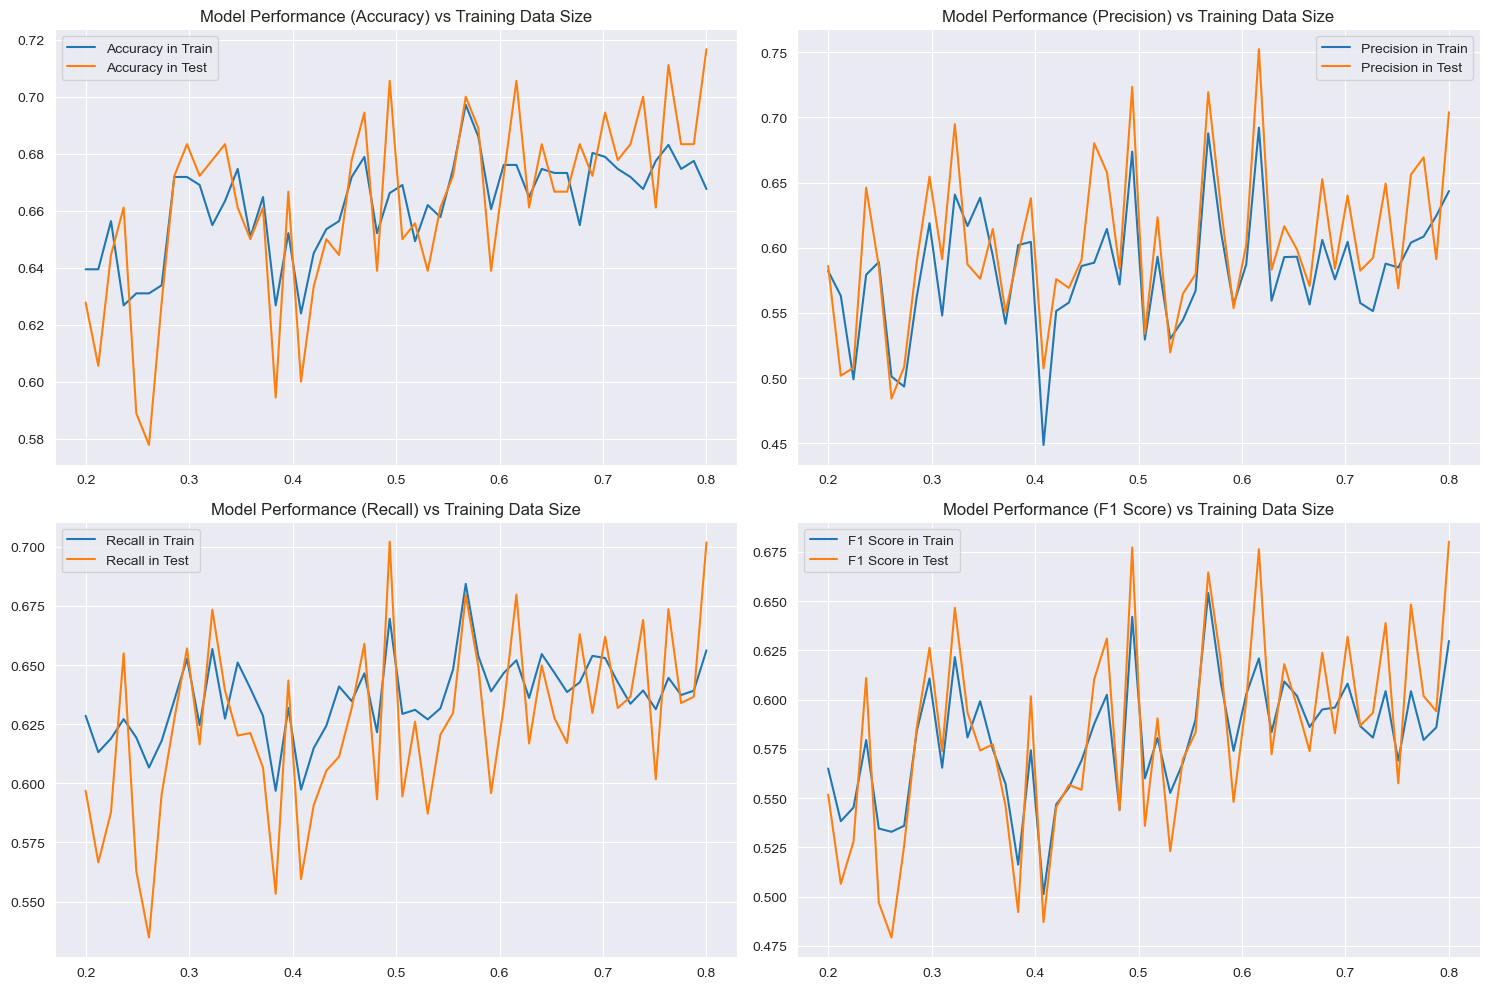

In [46]:
# Set a fixed random seed for reproducibility
np.random.seed(seed)

# Generate evenly spaced training data sizes between 0.2 and 0.8
training_sizes = np.linspace(0.2, 0.8, 50)

# Lists to store average values for Accuracy, Precision, Recall, and F1 score for train and test
train_accuracies = []
test_accuracies = []
train_precisions = []
test_precisions = []
train_recalls = []
test_recalls = []
train_f1s = []
test_f1s = []

batch_size = 64

for size in training_sizes:
    num_samples_train = int(size * len(X_train))
    num_samples_test = int((1 - size) * len(X_test))
    num_repeats = 5
    
    train_accuracy_sum = test_accuracy_sum = train_precision_sum = test_precision_sum = 0
    train_recall_sum = test_recall_sum = train_f1_sum = test_f1_sum = 0
    
    optimizer = SGD(learning_rate=1/1e+5, max_iters=1000, verbose=False, record_history=False, batch_size=int(batch_size * size))
    
    for _ in range(num_repeats):
        random_indices_train = np.random.choice(len(X_train), num_samples_train, replace=False)
        X_subset_train = X_train[random_indices_train]
        y_subset_train = y_train[random_indices_train]
        
        random_indices_test = np.random.choice(len(X_test), num_samples_test, replace=False)
        X_subset_test = X_test[random_indices_test]
        y_subset_test = y_test[random_indices_test]
        
        model_softmax.fit(X_subset_train, y_subset_train, optimizer)
        
        train_prediction = model_softmax.predict(X_train)
        test_prediction = model_softmax.predict(X_test)
        
        # Convert to binary format
        argmax_indices_train = np.argmax(train_prediction, axis=1)
        prediction_train = np.zeros_like(train_prediction)
        prediction_train[np.arange(len(train_prediction)), argmax_indices_train] = 1
        
        argmax_indices_test = np.argmax(test_prediction, axis=1)
        prediction_test = np.zeros_like(test_prediction)
        prediction_test[np.arange(len(test_prediction)), argmax_indices_test] = 1
        
        # Calculate the metrics
        train_accuracy_sum += accuracy_score_custom(y_train, prediction_train)
        test_accuracy_sum += accuracy_score_custom(y_test, prediction_test)
        train_precision_sum += precision_score_custom(y_train, prediction_train)
        test_precision_sum += precision_score_custom(y_test, prediction_test)
        train_recall_sum += recall_score_custom(y_train, prediction_train)
        test_recall_sum += recall_score_custom(y_test, prediction_test)
        train_f1_sum += f1_score_custom(y_train, prediction_train)
        test_f1_sum += f1_score_custom(y_test, prediction_test)
    
    # Calculate the average metric values for train and test
    train_accuracies.append(train_accuracy_sum / num_repeats)
    test_accuracies.append(test_accuracy_sum / num_repeats)
    train_precisions.append(train_precision_sum / num_repeats)
    test_precisions.append(test_precision_sum / num_repeats)
    train_recalls.append(train_recall_sum / num_repeats)
    test_recalls.append(test_recall_sum / num_repeats)
    train_f1s.append(train_f1_sum / num_repeats)
    test_f1s.append(test_f1_sum / num_repeats)

# Plot the curves for each metric
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

axs[0, 0].plot(training_sizes, train_accuracies, label='Accuracy in Train')
axs[0, 0].plot(training_sizes, test_accuracies, label='Accuracy in Test')
axs[0, 0].set_title('Model Performance (Accuracy) vs Training Data Size')
axs[0, 0].legend()
axs[0, 0].grid(True)

axs[0, 1].plot(training_sizes, train_precisions, label='Precision in Train')
axs[0, 1].plot(training_sizes, test_precisions, label='Precision in Test')
axs[0, 1].set_title('Model Performance (Precision) vs Training Data Size')
axs[0, 1].legend()
axs[0, 1].grid(True)

axs[1, 0].plot(training_sizes, train_recalls, label='Recall in Train')
axs[1, 0].plot(training_sizes, test_recalls, label='Recall in Test')
axs[1, 0].set_title('Model Performance (Recall) vs Training Data Size')
axs[1, 0].legend()
axs[1, 0].grid(True)

axs[1, 1].plot(training_sizes, train_f1s, label='F1 Score in Train')
axs[1, 1].plot(training_sizes, test_f1s, label='F1 Score in Test')
axs[1, 1].set_title('Model Performance (F1 Score) vs Training Data Size')
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# Assuming you have the necessary imports and functions defined previously

# Set a fixed random seed for reproducibility
np.random.seed(seed)

# Generate evenly spaced training data sizes between 0.2 and 0.8
training_sizes = np.linspace(0.2, 0.8, 50)

# Lists to store average values for Accuracy for train and test
train_accuracies = []
test_accuracies = []

batch_size = 128

for size in training_sizes:
    num_samples_train = int(size * len(X_train))
    num_samples_test = int((1 - size) * len(X_test))
    num_repeats = 3
    
    train_accuracy_sum = test_accuracy_sum = 0
    
    optimizer = SGD(learning_rate=1/1e+5, max_iters=10000, verbose=False, record_history=False, batch_size=int(batch_size * size))
    
    for _ in range(num_repeats):
        random_indices_train = np.random.choice(len(X_train), num_samples_train, replace=False)
        X_subset_train = X_train[random_indices_train]
        y_subset_train = y_train[random_indices_train]
        
        random_indices_test = np.random.choice(len(X_test), num_samples_test, replace=False)
        X_subset_test = X_test[random_indices_test]
        y_subset_test = y_test[random_indices_test]
        
        model_softmax.fit(X_subset_train, y_subset_train, optimizer)
        
        train_prediction = model_softmax.predict(X_train)
        test_prediction = model_softmax.predict(X_test)
        
        # Convert to binary format
        argmax_indices_train = np.argmax(train_prediction, axis=1)
        prediction_train = np.zeros_like(train_prediction)
        prediction_train[np.arange(len(train_prediction)), argmax_indices_train] = 1
        
        argmax_indices_test = np.argmax(test_prediction, axis=1)
        prediction_test = np.zeros_like(test_prediction)
        prediction_test[np.arange(len(test_prediction)), argmax_indices_test] = 1
        
        # Calculate the metrics
        train_accuracy_sum += accuracy_score_custom(y_train, prediction_train)
        test_accuracy_sum += accuracy_score_custom(y_test, prediction_test)
        
    # Calculate the average metric values for train and test
    train_accuracies.append(train_accuracy_sum / num_repeats)
    test_accuracies.append(test_accuracy_sum / num_repeats)

# Plot the curve for accuracy
plt.figure(figsize=(5, 4))
plt.plot(training_sizes, train_accuracies, label='Accuracy in Train')
plt.plot(training_sizes, test_accuracies, label='Accuracy in Test')
# plt.title('Model Performance (Accuracy) vs Training Data Size')
plt.xlabel('Training Data Size')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Test the Model Performance with different batch size

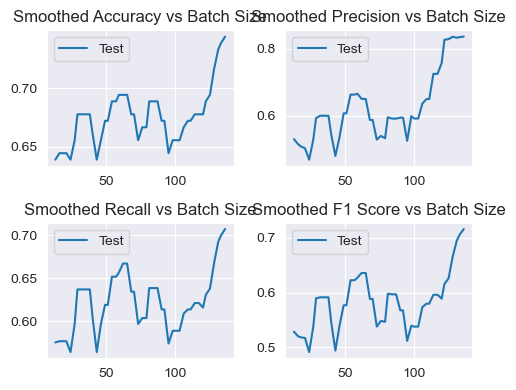

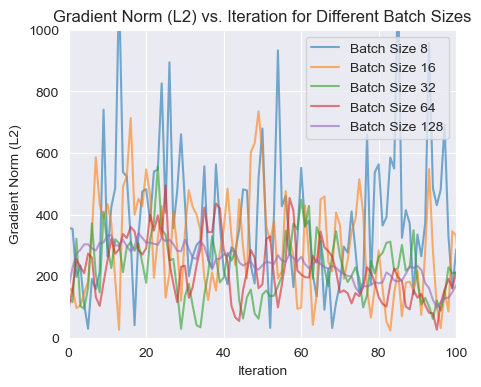

In [11]:
np.random.seed(seed)
batch_sizes = np.linspace(8, 142, 50, dtype=int)

test_accuracies = []
test_precisions = []
test_recalls = []
test_f1s = []

for batch_size in batch_sizes:
    optimizer = SGD(learning_rate=1/1e+5, max_iters=1000, record_history=True, batch_size=batch_size)
    model_softmax.fit(X_train, y_train, optimizer)
    
    test_prediction = model_softmax.predict(X_test)
    
    argmax_indices_test = np.argmax(test_prediction, axis=1)
    prediction_test = np.zeros_like(test_prediction)
    prediction_test[np.arange(len(test_prediction)), argmax_indices_test] = 1
    
    test_accuracies.append(accuracy_score_custom(y_test, prediction_test))
    test_precisions.append(precision_score_custom(y_test, prediction_test))
    test_recalls.append(recall_score_custom(y_test, prediction_test))
    test_f1s.append(f1_score_custom(y_test, prediction_test))


test_accuracies_series = pd.Series(test_accuracies)
test_precisions_series = pd.Series(test_precisions)
test_recalls_series = pd.Series(test_recalls)
test_f1s_series = pd.Series(test_f1s)


window_size = 5
smooth_test_accuracies = test_accuracies_series.rolling(window=window_size, center=True).mean().dropna()
smooth_test_precisions = test_precisions_series.rolling(window=window_size, center=True).mean().dropna()
smooth_test_recalls = test_recalls_series.rolling(window=window_size, center=True).mean().dropna()
smooth_test_f1s = test_f1s_series.rolling(window=window_size, center=True).mean().dropna()


offset = (window_size - 1) // 2
smooth_batch_sizes = batch_sizes[offset:-offset]

fig, axs = plt.subplots(2, 2, figsize=(5, 4))

axs[0, 0].plot(smooth_batch_sizes, smooth_test_accuracies, label='Test')
axs[0, 0].set_title('Smoothed Accuracy vs Batch Size')
axs[0, 0].legend()
axs[0, 0].grid(True)

axs[0, 1].plot(smooth_batch_sizes, smooth_test_precisions, label='Test')
axs[0, 1].set_title('Smoothed Precision vs Batch Size')
axs[0, 1].legend()
axs[0, 1].grid(True)

axs[1, 0].plot(smooth_batch_sizes, smooth_test_recalls, label='Test')
axs[1, 0].set_title('Smoothed Recall vs Batch Size')
axs[1, 0].legend()
axs[1, 0].grid(True)

axs[1, 1].plot(smooth_batch_sizes, smooth_test_f1s, label='Test')
axs[1, 1].set_title('Smoothed F1 Score vs Batch Size')
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()

#//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

# List of batch sizes to iterate over
batch_sizes = [8, 16, 32, 64, 128]
# Lists to store MSE values and gradient histories for each batch size
mse_values = []
grad_histories = []

for batch_size in batch_sizes:
    # Create a new SGD instance with the current batch size
    optimizer = SGD(learning_rate=1/1e+5, max_iters=500, record_history=True, batch_size=int(batch_size))

    # Train the model on the training data
    model_softmax.fit(X_train, y_train, optimizer)

    # Make predictions on the test set
    prediction = model_softmax.predict(X_test)

    # Calculate the Mean Squared Error (MSE) for the predictions
    mse = calculate_mse(y_test, prediction)
    mse_values.append(mse)

    # Store the gradient history for this batch size
    grad_histories.append(optimizer.grad_history)

# Plot the gradient changes for different batch sizes
plt.figure(figsize=(5, 4))
for i, batch_size in enumerate(batch_sizes):
    plt.plot(range(len(grad_histories[i])), [np.linalg.norm(grad, ord=2) for grad in grad_histories[i]], label=f'Batch Size {batch_size}', alpha=0.6)

plt.xlabel('Iteration')
plt.ylabel('Gradient Norm (L2)')
plt.title('Gradient Norm (L2) vs. Iteration for Different Batch Sizes')
plt.legend()
plt.grid(True)
plt.ylim(0, 1000)
plt.xlim(0, 100)
plt.show()


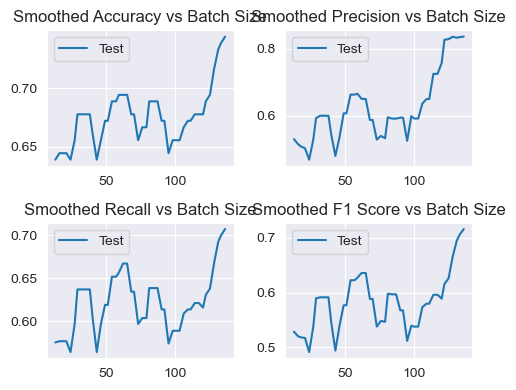

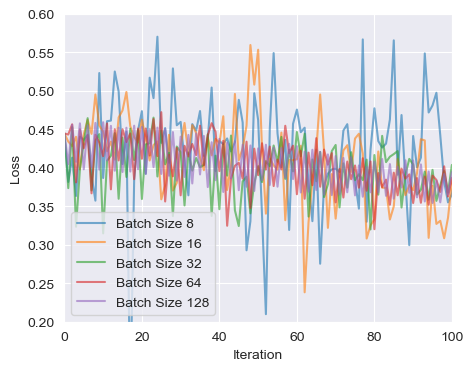

In [36]:
np.random.seed(seed)
batch_sizes = np.linspace(8, 142, 50, dtype=int)

test_accuracies = []
test_precisions = []
test_recalls = []
test_f1s = []

for batch_size in batch_sizes:
    optimizer = SGD(learning_rate=1/1e+5, max_iters=1000, record_history=True, batch_size=batch_size)
    model_softmax.fit(X_train, y_train, optimizer)
    
    test_prediction = model_softmax.predict(X_test)
    
    argmax_indices_test = np.argmax(test_prediction, axis=1)
    prediction_test = np.zeros_like(test_prediction)
    prediction_test[np.arange(len(test_prediction)), argmax_indices_test] = 1
    
    test_accuracies.append(accuracy_score_custom(y_test, prediction_test))
    test_precisions.append(precision_score_custom(y_test, prediction_test))
    test_recalls.append(recall_score_custom(y_test, prediction_test))
    test_f1s.append(f1_score_custom(y_test, prediction_test))


test_accuracies_series = pd.Series(test_accuracies)
test_precisions_series = pd.Series(test_precisions)
test_recalls_series = pd.Series(test_recalls)
test_f1s_series = pd.Series(test_f1s)


window_size = 5
smooth_test_accuracies = test_accuracies_series.rolling(window=window_size, center=True).mean().dropna()
smooth_test_precisions = test_precisions_series.rolling(window=window_size, center=True).mean().dropna()
smooth_test_recalls = test_recalls_series.rolling(window=window_size, center=True).mean().dropna()
smooth_test_f1s = test_f1s_series.rolling(window=window_size, center=True).mean().dropna()


offset = (window_size - 1) // 2
smooth_batch_sizes = batch_sizes[offset:-offset]

fig, axs = plt.subplots(2, 2, figsize=(5, 4))

axs[0, 0].plot(smooth_batch_sizes, smooth_test_accuracies, label='Test')
axs[0, 0].set_title('Smoothed Accuracy vs Batch Size')
axs[0, 0].legend()
axs[0, 0].grid(True)

axs[0, 1].plot(smooth_batch_sizes, smooth_test_precisions, label='Test')
axs[0, 1].set_title('Smoothed Precision vs Batch Size')
axs[0, 1].legend()
axs[0, 1].grid(True)

axs[1, 0].plot(smooth_batch_sizes, smooth_test_recalls, label='Test')
axs[1, 0].set_title('Smoothed Recall vs Batch Size')
axs[1, 0].legend()
axs[1, 0].grid(True)

axs[1, 1].plot(smooth_batch_sizes, smooth_test_f1s, label='Test')
axs[1, 1].set_title('Smoothed F1 Score vs Batch Size')
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()

#//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

# List of batch sizes to iterate over
batch_sizes = [8, 16, 32, 64, 128]
# Lists to store MSE values and gradient histories for each batch size
mse_values = []
loss_histories = []

for batch_size in batch_sizes:
    # Create a new SGD instance with the current batch size
    optimizer = SGD(learning_rate=1/1e+5, max_iters=500, record_history=True, batch_size=int(batch_size))

    # Train the model on the training data
    model_softmax.fit(X_train, y_train, optimizer)

    # Store the loss history for this batch size
    loss_histories.append(optimizer.loss_history)

# Plot the loss changes for different batch sizes
plt.figure(figsize=(5, 4))
for i, batch_size in enumerate(batch_sizes):
    plt.plot(range(len(loss_histories[i])), loss_histories[i], label=f'Batch Size {batch_size}', alpha=0.6)

plt.xlabel('Iteration')
plt.ylabel('Loss')
# plt.title('Loss vs. Iteration for Different Batch Sizes')
plt.legend()
plt.grid(True)
plt.ylim(0.2,0.6)
plt.xlim(0,100)
plt.show()

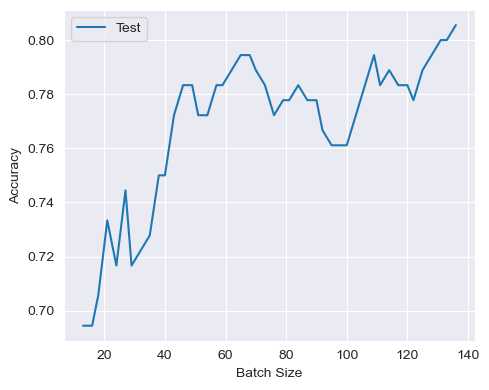

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Assuming you have the necessary imports and functions defined previously

np.random.seed(seed)

# Generate evenly spaced batch sizes
batch_sizes = np.linspace(8, 142, 50, dtype=int)

# Lists to store average values for Accuracy for test
test_accuracies = []

for batch_size in batch_sizes:
    optimizer = SGD(learning_rate=1/1e+5, max_iters=5000, record_history=True, batch_size=batch_size)
    model_softmax.fit(X_train, y_train, optimizer)
    
    test_prediction = model_softmax.predict(X_test)
    
    argmax_indices_test = np.argmax(test_prediction, axis=1)
    prediction_test = np.zeros_like(test_prediction)
    prediction_test[np.arange(len(test_prediction)), argmax_indices_test] = 1
    
    test_accuracies.append(accuracy_score_custom(y_test, prediction_test))

test_accuracies_series = pd.Series(test_accuracies)

window_size = 5
smooth_test_accuracies = test_accuracies_series.rolling(window=window_size, center=True).mean().dropna()

offset = (window_size - 1) // 2
smooth_batch_sizes = batch_sizes[offset:-offset]

# Plot the curve for smoothed accuracy
plt.figure(figsize=(5, 4))
plt.plot(smooth_batch_sizes, smooth_test_accuracies, label='Test')
# plt.title('Accuracy vs Batch Size')
plt.xlabel('Batch Size')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Test the Model Performance with different learning rates

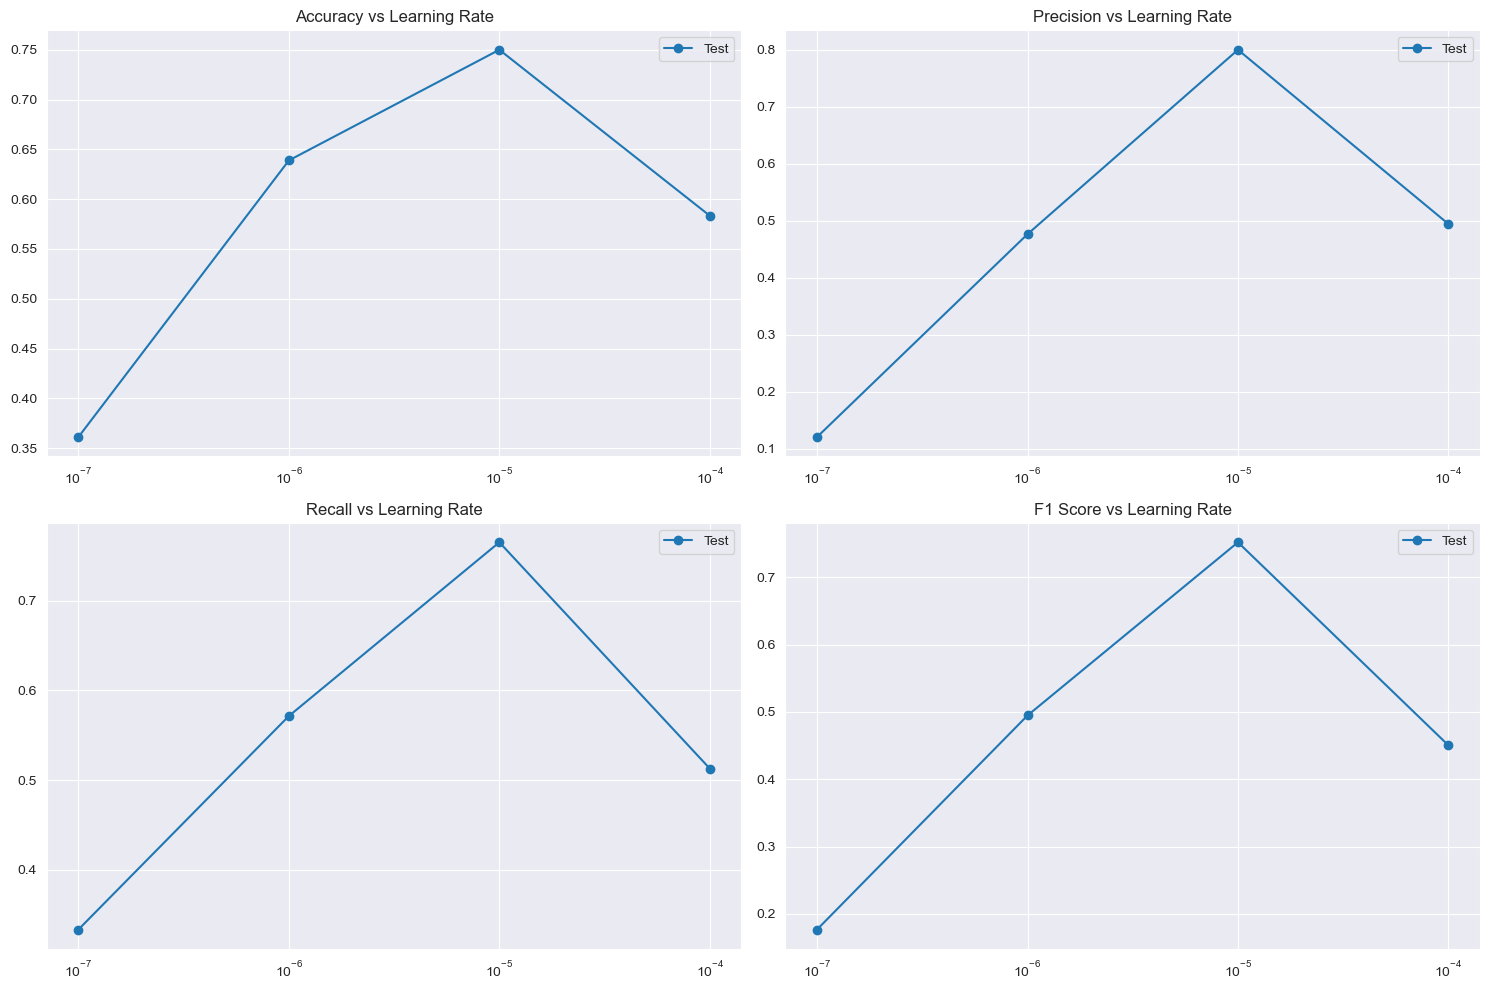

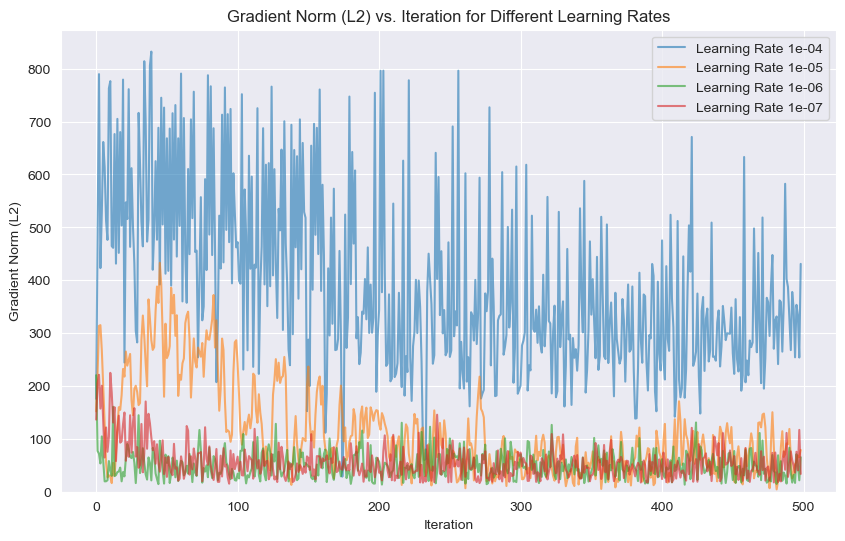

In [34]:
np.random.seed(seed)
learning_rates = [1/1e+4, 1/1e+5, 1/1e+6, 1/1e+7]

test_accuracies = []
test_precisions = []
test_recalls = []
test_f1s = []
grad_histories = []  # List to store gradient histories for each learning rate

for learning_rate in learning_rates:
    optimizer = SGD(learning_rate=learning_rate, max_iters=500, record_history=True, batch_size=64)  
    model_softmax.fit(X_train, y_train, optimizer)
    
    test_prediction = model_softmax.predict(X_test)
    
    argmax_indices_test = np.argmax(test_prediction, axis=1)
    prediction_test = np.zeros_like(test_prediction)
    prediction_test[np.arange(len(test_prediction)), argmax_indices_test] = 1
    
    test_accuracies.append(accuracy_score_custom(y_test, prediction_test))
    test_precisions.append(precision_score_custom(y_test, prediction_test))
    test_recalls.append(recall_score_custom(y_test, prediction_test))
    test_f1s.append(f1_score_custom(y_test, prediction_test))
    
    grad_histories.append(optimizer.grad_history)  # Save the gradient history for this learning rate

# Plotting the Performance Metrics
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

axs[0, 0].plot(learning_rates, test_accuracies, label='Test', marker='o')
axs[0, 0].set_title('Accuracy vs Learning Rate')
axs[0, 0].set_xscale('log')
axs[0, 0].legend()
axs[0, 0].grid(True)

axs[0, 1].plot(learning_rates, test_precisions, label='Test', marker='o')
axs[0, 1].set_title('Precision vs Learning Rate')
axs[0, 1].set_xscale('log')
axs[0, 1].legend()
axs[0, 1].grid(True)

axs[1, 0].plot(learning_rates, test_recalls, label='Test', marker='o')
axs[1, 0].set_title('Recall vs Learning Rate')
axs[1, 0].set_xscale('log')
axs[1, 0].legend()
axs[1, 0].grid(True)

axs[1, 1].plot(learning_rates, test_f1s, label='Test', marker='o')
axs[1, 1].set_title('F1 Score vs Learning Rate')
axs[1, 1].set_xscale('log')
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()

# Plotting the Gradient Histories
plt.figure(figsize=(10, 6))
for i, learning_rate in enumerate(learning_rates):
    plt.plot(range(len(grad_histories[i])), [np.linalg.norm(grad, ord=2) for grad in grad_histories[i]], label=f'Learning Rate {learning_rate:.0e}', alpha=0.6)

plt.xlabel('Iteration')
plt.ylabel('Gradient Norm (L2)')
plt.title('Gradient Norm (L2) vs. Iteration for Different Learning Rates')
plt.legend()
plt.grid(True)
plt.ylim(0)
plt.show()


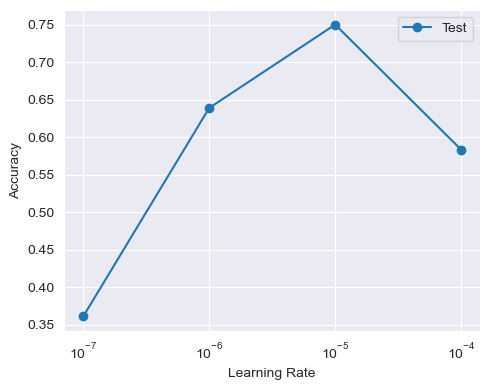

In [36]:
import numpy as np
import matplotlib.pyplot as plt
# Assuming you have the necessary imports and functions defined previously

np.random.seed(seed)
learning_rates = [1/1e+4, 1/1e+5, 1/1e+6, 1/1e+7]

test_accuracies = []

for learning_rate in learning_rates:
    optimizer = SGD(learning_rate=learning_rate, max_iters=500, record_history=True, batch_size=64)  
    model_softmax.fit(X_train, y_train, optimizer)
    
    test_prediction = model_softmax.predict(X_test)
    
    argmax_indices_test = np.argmax(test_prediction, axis=1)
    prediction_test = np.zeros_like(test_prediction)
    prediction_test[np.arange(len(test_prediction)), argmax_indices_test] = 1
    
    test_accuracies.append(accuracy_score_custom(y_test, prediction_test))

# Plotting the Accuracy
plt.figure(figsize=(5, 4))
plt.plot(learning_rates, test_accuracies, label='Test', marker='o')
# plt.title('Accuracy vs Learning Rate')
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Test the model performance with data normalized

5-cross_Average Accuracy: 0.98
5-cross_Average Precision: 0.98
5-cross_Average Recall: 0.98
5-cross_Average F1 Score: 0.98


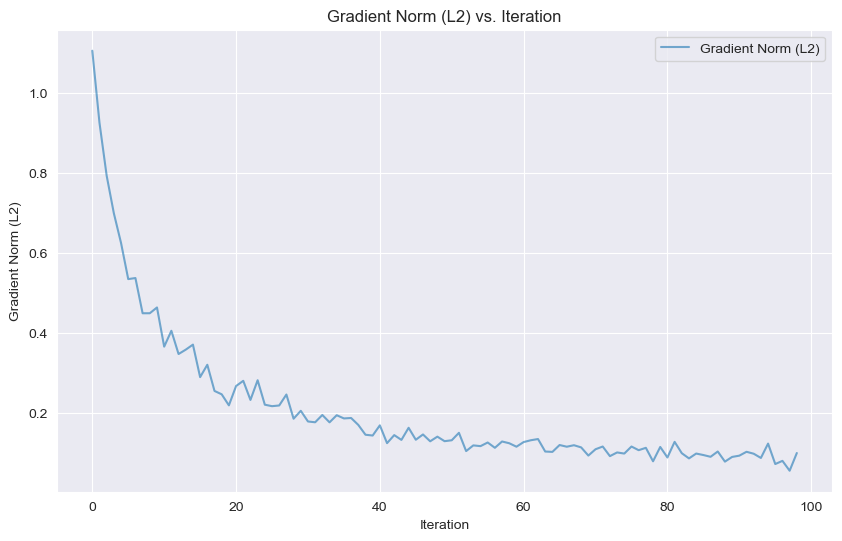

In [7]:
from sklearn.model_selection import KFold

np.random.seed(seed)

# Perform Z-score normalization on the entire dataset
mean = np.mean(X, axis=0)
std = np.std(X, axis=0)
X_normalized = (X - mean) / std

# Initialize performance metrics
accuracies = []
precisions = []
recalls = []
f1s = []
grad_histories = []

# 5-fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=seed)
for train_index, test_index in kf.split(X_normalized):
    X_train, X_test = X_normalized[train_index], X_normalized[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    optimizer = SGD(learning_rate=0.1, max_iters=100, verbose=False, batch_size=64, record_history=True)
    model_softmax = SoftmaxRegression()
    model_softmax.fit(X_train, y_train, optimizer)
    
    y_train_pred = model_softmax.predict(X_test)
    
    argmax_indices = np.argmax(y_train_pred, axis=1)
    prediction = np.zeros_like(y_train_pred)
    prediction[np.arange(len(y_train_pred)), argmax_indices] = 1
    
    accuracies.append(accuracy_score_custom(y_test, prediction))
    precisions.append(precision_score_custom(y_test, prediction))
    recalls.append(recall_score_custom(y_test, prediction))
    f1s.append(f1_score_custom(y_test, prediction))
    
    grad_histories.append(optimizer.grad_history)

# Calculate average performance metrics
print(f"5-cross_Average Accuracy: {np.mean(accuracies):.2f}")
print(f"5-cross_Average Precision: {np.mean(precisions):.2f}")
print(f"5-cross_Average Recall: {np.mean(recalls):.2f}")
print(f"5-cross_Average F1 Score: {np.mean(f1s):.2f}")

# Plot the gradient change curve
plt.figure(figsize=(10, 6))
plt.plot(range(len(grad_histories[0])), [np.linalg.norm(grad, ord=2) for grad in grad_histories[0]], label='Gradient Norm (L2)', alpha=0.6)
plt.xlabel('Iteration')
plt.ylabel('Gradient Norm (L2)')
plt.title('Gradient Norm (L2) vs. Iteration')
plt.legend()
plt.grid(True)
plt.show()


5-cross_Average Accuracy: 0.99
5-cross_Average Precision: 0.99
5-cross_Average Recall: 0.99
5-cross_Average F1 Score: 0.99


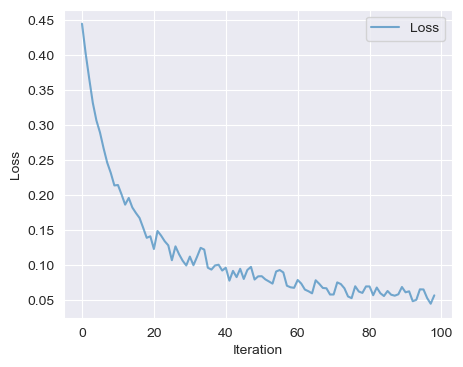

In [8]:

# Lists to store loss histories for each fold
loss_histories = []

# 5-fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=seed)
for train_index, test_index in kf.split(X_normalized):
    X_train, X_test = X_normalized[train_index], X_normalized[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    optimizer = SGD(learning_rate=0.1, max_iters=100, verbose=False, batch_size=64, record_history=True)
    model_softmax = SoftmaxRegression()
    model_softmax.fit(X_train, y_train, optimizer)
    
    y_train_pred = model_softmax.predict(X_test)
    
    argmax_indices = np.argmax(y_train_pred, axis=1)
    prediction = np.zeros_like(y_train_pred)
    prediction[np.arange(len(y_train_pred)), argmax_indices] = 1
    
    accuracies.append(accuracy_score_custom(y_test, prediction))
    precisions.append(precision_score_custom(y_test, prediction))
    recalls.append(recall_score_custom(y_test, prediction))
    f1s.append(f1_score_custom(y_test, prediction))
    
    loss_histories.append(optimizer.loss_history)

# Calculate average performance metrics
print(f"5-cross_Average Accuracy: {np.mean(accuracies):.2f}")
print(f"5-cross_Average Precision: {np.mean(precisions):.2f}")
print(f"5-cross_Average Recall: {np.mean(recalls):.2f}")
print(f"5-cross_Average F1 Score: {np.mean(f1s):.2f}")

# Plot the loss change curve
plt.figure(figsize=(5, 4))
plt.plot(range(len(loss_histories[0])), loss_histories[0], label='Loss', alpha=0.6)
plt.xlabel('Iteration')
plt.ylabel('Loss')
# plt.title('Loss vs. Iteration with data normalization')
plt.legend()
plt.grid(True)
plt.show()


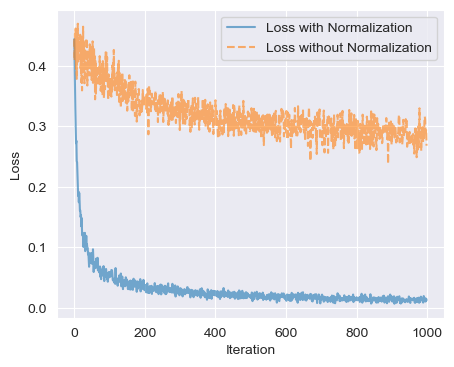

In [12]:
# Lists to store loss histories for each fold
normalized_loss_histories = []
non_normalized_loss_histories = []

# 5-fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=seed)

# Define a helper function to fit the model and return the loss history
def fit_and_get_loss_history(X_train, y_train, X_test, optimizer, model):
    model.fit(X_train, y_train, optimizer)
    y_train_pred = model.predict(X_test)
    argmax_indices = np.argmax(y_train_pred, axis=1)
    prediction = np.zeros_like(y_train_pred)
    prediction[np.arange(len(y_train_pred)), argmax_indices] = 1
    return optimizer.loss_history

for train_index, test_index in kf.split(X_normalized):
    X_train_norm, X_test_norm = X_normalized[train_index], X_normalized[test_index]
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    optimizer_norm = SGD(learning_rate=0.1, max_iters=1000, verbose=False, batch_size=64, record_history=True)
    model_softmax_norm = SoftmaxRegression()
    normalized_loss_histories.append(fit_and_get_loss_history(X_train_norm, y_train, X_test_norm, optimizer_norm, model_softmax_norm))
    
    optimizer = SGD(learning_rate=1e-5, max_iters=1000, verbose=False, batch_size=64, record_history=True)
    model_softmax = SoftmaxRegression()
    non_normalized_loss_histories.append(fit_and_get_loss_history(X_train, y_train, X_test, optimizer, model_softmax))

# Plot the loss change curve
plt.figure(figsize=(5, 4))
# assuming we're plotting the first fold; adjust index as needed
plt.plot(range(len(normalized_loss_histories[0])), normalized_loss_histories[0], label='Loss with Normalization', alpha=0.6)
plt.plot(range(len(non_normalized_loss_histories[0])), non_normalized_loss_histories[0], label='Loss without Normalization', alpha=0.6, linestyle='dashed')
plt.xlabel('Iteration')
plt.ylabel('Loss')
# plt.title('Loss vs. Iteration with/without normalized')
plt.legend()
plt.grid(True)
plt.show()
